In [1]:
path = '/media/cilab/data/NTIRE/flare/iitm_dataset'

In [2]:
from diffusers import UNet2DModel, DDIMScheduler, VQModel
import torch
import PIL.Image
import numpy as np
import tqdm

seed = 3

# load all models
unet = UNet2DModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="unet")
vqvae = VQModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae")
scheduler = DDIMScheduler.from_config("CompVis/ldm-celebahq-256", subfolder="scheduler")

# set to cuda
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

unet.to(torch_device)
vqvae.to(torch_device)

print("loaded the models")

/home/cilab/anaconda3/envs/manimate/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cilab/anaconda3/envs/manimate/lib/python3.8/site-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuratio

loaded the models


In [4]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [5]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [6]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub


config = TrainingConfig()

In [7]:
import glob
import os
import glob
from torchvision import transforms


class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.path = path
        self.files = glob.glob(os.path.join(path, "*.jpg"))
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img = PIL.Image.open(self.files[idx]).convert("RGB")

        tf = transforms.Compose(
                [
                transforms.Resize((config.image_size, config.image_size)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

        img = tf(img)
        return img
    

In [8]:
dataset = ImageDataset(path)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [10]:
for inputs in train_dataloader:
    inputs = inputs.to('cpu')
    break

inputs.shape

torch.Size([16, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

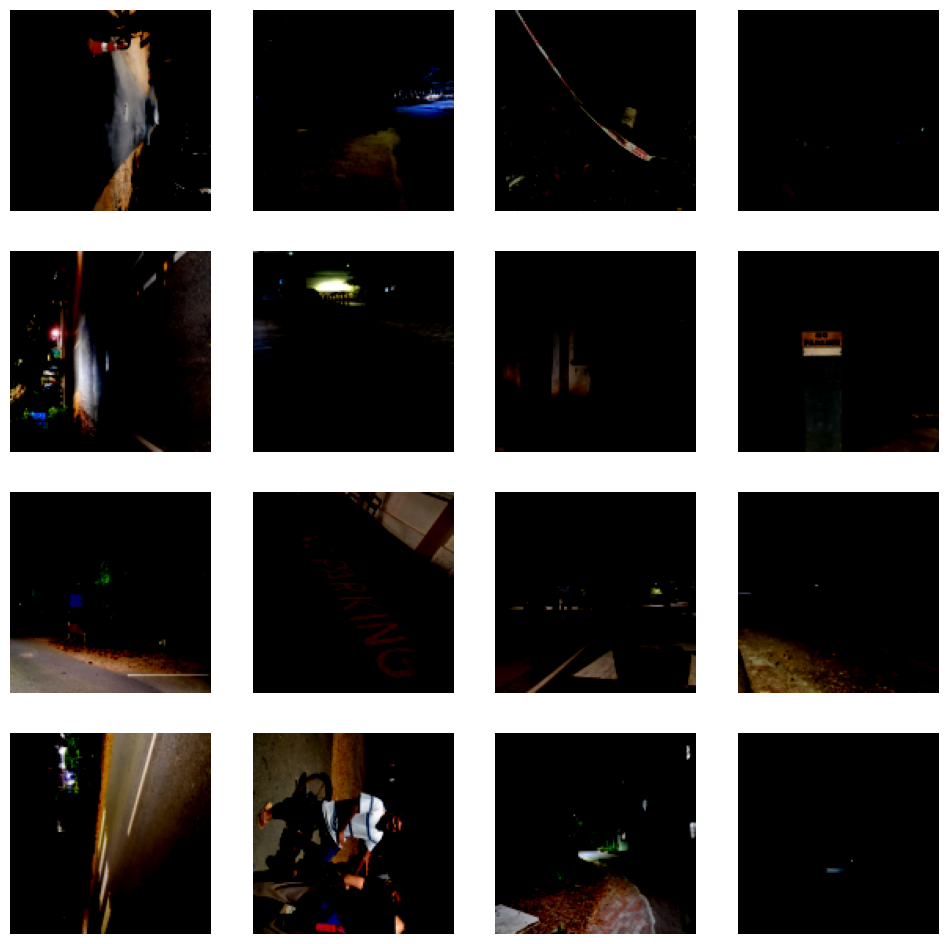

In [34]:
# plot the grid of images
import matplotlib.pyplot as plt

def plot_grid(images, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    for i in range(rows):
        for j in range(cols):
            ax[i, j].imshow(images[i * cols + j].permute(1, 2, 0).cpu().numpy())
            ax[i, j].axis("off")
    plt.show()

plot_grid(inputs, 4, 4)

In [15]:
sample_image = dataset[0].unsqueeze(0)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


In [19]:
sample_image = sample_image.to('cuda')

# Checking the latent space.

In [29]:
latents = vqvae.encode(sample_image).latents
image = vqvae.decode(latents).sample

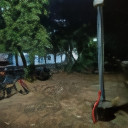

In [33]:
op = image.cpu().detach().numpy()
op = np.squeeze(op)
op = np.transpose(op, (1, 2, 0))
op = (op + 1) / 2
PIL.Image.fromarray((op * 255).astype(np.uint8))

# Training the Model

In [35]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [36]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [37]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
import torch.nn.functional as F

def train_loop(config, model, 
               noise_scheduler, optimizer, 
               train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

: 

In [9]:
# generate gaussian noise to be decoded
generator = torch.manual_seed(seed)
noise = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(torch_device)

# set inference steps for DDIM
scheduler.set_timesteps(num_inference_steps=200)

image = noise
for t in tqdm.tqdm(scheduler.timesteps):
    # predict noise residual of previous image
    with torch.no_grad():
        residual = unet(image, t)["sample"]

    # compute previous image x_t according to DDIM formula
    prev_image = scheduler.step(residual, t, image, eta=0.0)["prev_sample"]

    # x_t-1 -> x_t
    image = prev_image

# decode image with vae
with torch.no_grad():
    image = vqvae.decode(image)

# process image
image_processed = image.sample.cpu().permute(0, 2, 3, 1)
image_processed = (image_processed + 1.0) * 127.5
image_processed = image_processed.clamp(0, 255).numpy().astype(np.uint8)
image_pil = PIL.Image.fromarray(image_processed[0])


/tmp/ipykernel_80882/4077869463.py:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, unet.in_channels, unet.sample_size, unet.sample_size),
  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:05<00:00, 34.77it/s]


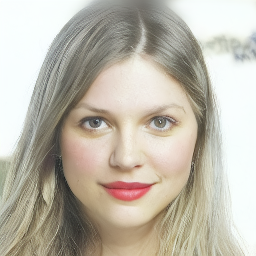

In [10]:
image_pil